c:\Users\crish\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\crish\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_discretization.py:307: UserWarning: Bins whose width are too small (i.e., <= 1e-8) in feature 0 are removed. Consider decreasing the number of bins.
  warnings.warn(


Número de linhas no dataset: 891
Primeiras linhas do dataset:
   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123     

  0%|          | 27/1000000 [00:00<3:04:51, 90.16it/s]



Melhor Estrutura Encontrada (Arestas - BIC Score):
[('Survived', 'Sex'), ('Pclass', 'Embarked'), ('Pclass', 'Survived'), ('Pclass', 'Age'), ('Parch', 'Fare'), ('Fare', 'Pclass'), ('Fare', 'SibSp')]

Estrutura alternativa (Arestas - K2 Score):
[('Survived', 'Fare'), ('Survived', 'Age'), ('Survived', 'SibSp'), ('Pclass', 'Fare'), ('Pclass', 'Age'), ('Pclass', 'Survived'), ('Pclass', 'SibSp'), ('Pclass', 'Sex'), ('Sex', 'Fare'), ('Sex', 'Survived'), ('Sex', 'Age'), ('Sex', 'SibSp'), ('Age', 'SibSp'), ('Parch', 'Fare'), ('Parch', 'SibSp'), ('Parch', 'Age'), ('Parch', 'Sex'), ('Fare', 'Age'), ('Fare', 'SibSp'), ('Embarked', 'Fare'), ('Embarked', 'Pclass'), ('Embarked', 'Age'), ('Embarked', 'SibSp'), ('Embarked', 'Sex')]

Tabelas de Probabilidade Condicional (CPDs) - BIC Score:
+-------------+---------------------+--------------------+---------------------+
| Pclass      | Pclass(1)           | Pclass(2)          | Pclass(3)           |
+-------------+---------------------+-----------------

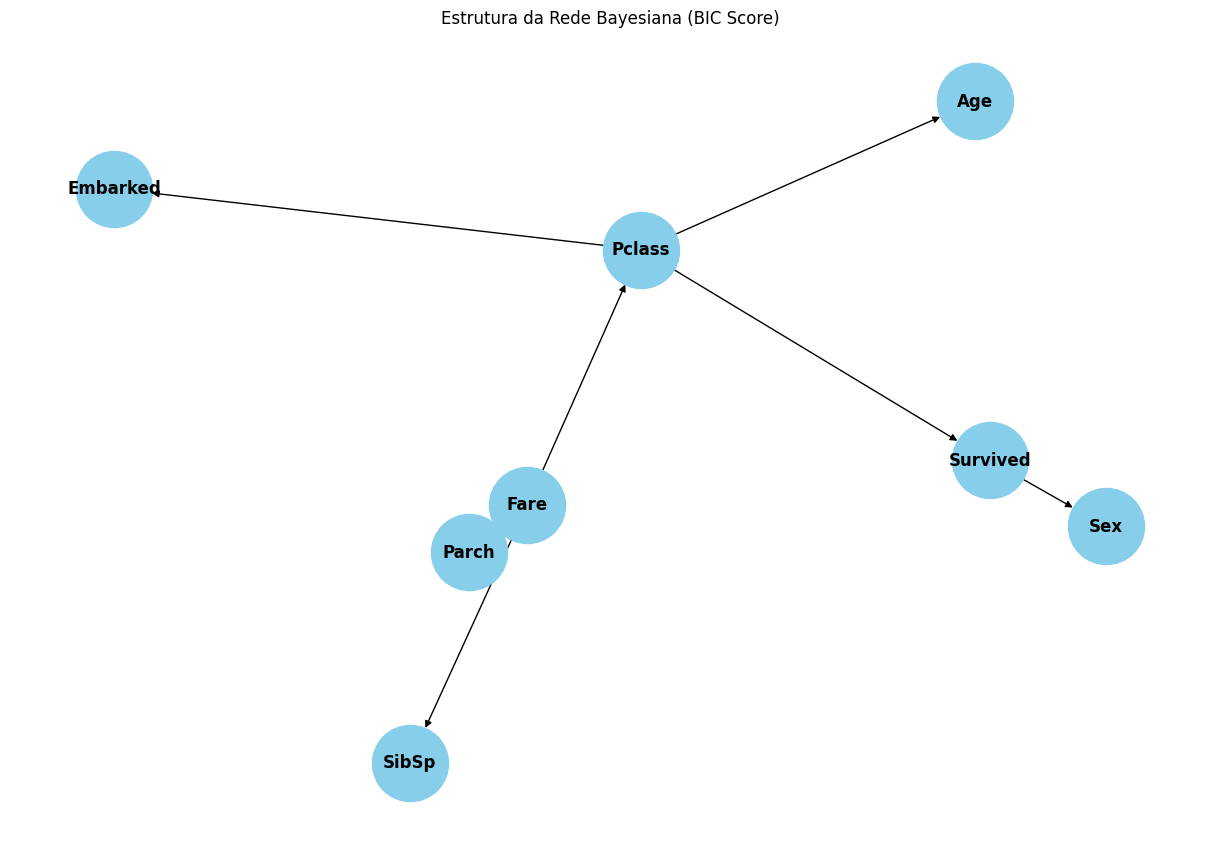

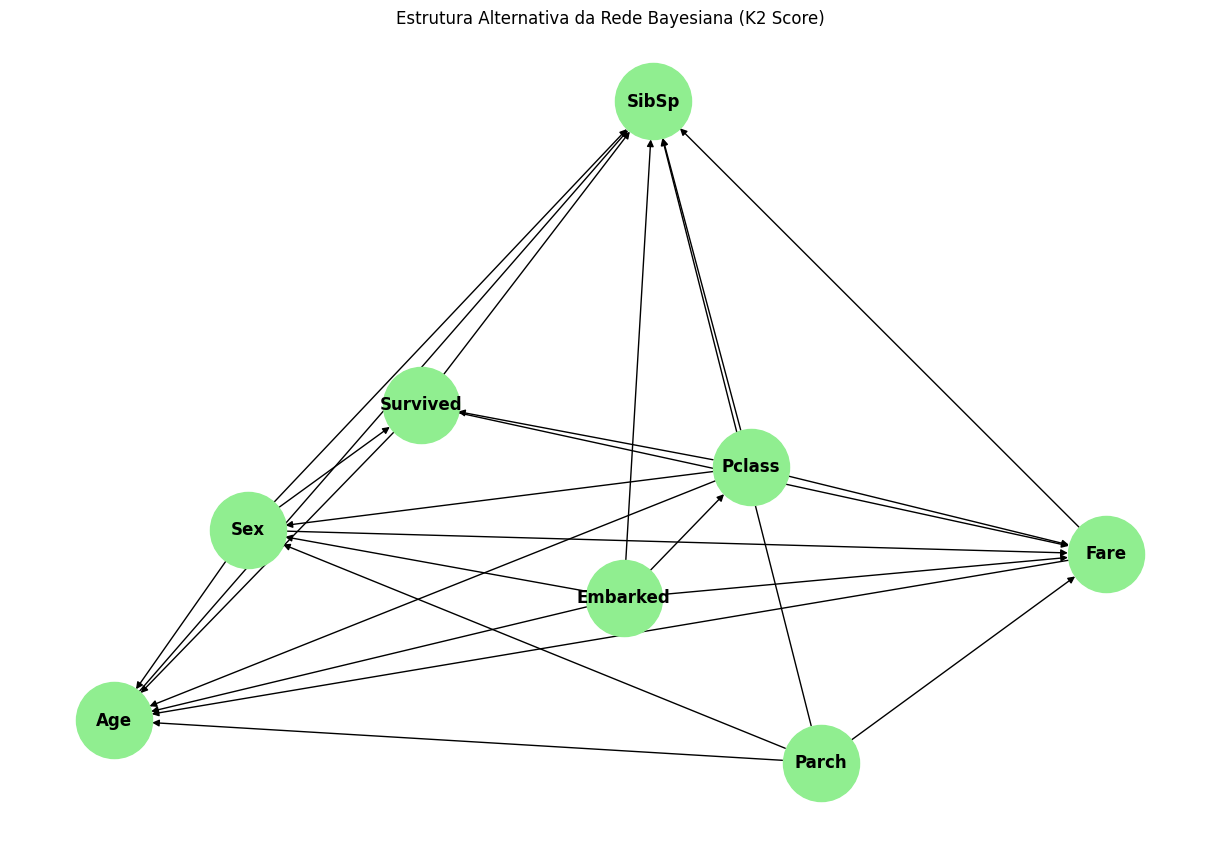

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, BicScore, K2Score, BayesianEstimator
import networkx as nx
import matplotlib.pyplot as plt

import pandas as pd

# Carregar o dataset Titanic do arquivo 'train.csv'
df = pd.read_csv('C:\\programação\\projeto de IA\\titanic\\train.csv')

# Confirme o número de linhas para garantir que está correto
print(f"Número de linhas no dataset: {len(df)}")  # Deve exibir 1309

# O restante do código continua igual


# Passo 3: Pré-processamento dos dados
# Exibir as primeiras linhas do dataset
print("Primeiras linhas do dataset:")
print(df.head())

# Verificar e preencher valores ausentes
print("\nValores ausentes por coluna:")
print(df.isnull().sum())

# Preencher valores ausentes em 'Age' com a mediana
if 'Age' in df.columns:
    df['Age'].fillna(df['Age'].median(), inplace=True)

# Preencher valores ausentes em 'Embarked' com o valor mais frequente
if 'Embarked' in df.columns:
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# Excluir a coluna 'Cabin' devido ao grande número de valores ausentes, se existir
if 'Cabin' in df.columns:
    df.drop(columns=['Cabin'], inplace=True)

# Converter 'Sex' para valores numéricos
if 'Sex' in df.columns:
    df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

# Converter 'Embarked' para valores numéricos
if 'Embarked' in df.columns:
    df['Embarked'] = df['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# Selecionar as colunas relevantes
relevant_columns = ['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
df = df[relevant_columns]

# Discretizar 'Age' e 'Fare' usando KBinsDiscretizer
age_discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
fare_discretizer = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')

# Ajustar e transformar a coluna 'Age'
df['Age'] = age_discretizer.fit_transform(df[['Age']]).astype(int)

# Ajustar e transformar a coluna 'Fare'
df['Fare'] = fare_discretizer.fit_transform(df[['Fare']]).astype(int)

# Converter todas as colunas para inteiro
df = df.astype(int)

# Verificar os dados após o pré-processamento
print("\nDados após o pré-processamento:")
print(df.head())

# Passo 4: Separar a variável alvo (Survived) das variáveis preditoras
X = df.drop('Survived', axis=1)
y = df['Survived']

# Passo 5: Dividir os dados em treinamento e teste
train_data, test_data = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['Survived']
)

print(f"\nConjunto de Treinamento: {len(train_data)} registros")
print(f"Conjunto de Teste: {len(test_data)} registros")

# Passo 6: Descobrir a melhor estrutura da Rede Bayesiana usando Hill Climbing e BIC Score
est_hc = HillClimbSearch(train_data)

# Estimar a estrutura com BIC Score
bic_model = est_hc.estimate(scoring_method=BicScore(train_data))

# Estimar a estrutura com K2 Score
k2_model = est_hc.estimate(scoring_method=K2Score(train_data))

# Passo 7: Treinar a Rede Bayesiana com a melhor estrutura encontrada

# Modelo com BIC Score
model_bic = BayesianNetwork(bic_model.edges())
model_bic.fit(train_data, estimator=BayesianEstimator, prior_type='BDeu')

# Modelo com K2 Score
model_k2 = BayesianNetwork(k2_model.edges())
model_k2.fit(train_data, estimator=BayesianEstimator, prior_type='BDeu')

# Passo 8: Imprimir a estrutura da rede e as Tabelas de Probabilidade Condicional (CPDs)
print("\nMelhor Estrutura Encontrada (Arestas - BIC Score):")
print(bic_model.edges())

print("\nEstrutura alternativa (Arestas - K2 Score):")
print(k2_model.edges())

print("\nTabelas de Probabilidade Condicional (CPDs) - BIC Score:")
for cpd in model_bic.get_cpds():
    print(cpd)

print("\nTabelas de Probabilidade Condicional (CPDs) - K2 Score:")
for cpd in model_k2.get_cpds():
    print(cpd)

# Passo 9: Desenhar o grafo da melhor estrutura usando BIC Score
plt.figure(figsize=(12, 8))
G_bic = nx.DiGraph(model_bic.edges())
pos_bic = nx.spring_layout(G_bic, seed=42)
nx.draw(G_bic, pos_bic, with_labels=True, node_size=3000, node_color="skyblue",
        font_size=12, font_weight="bold", arrows=True)
plt.title("Estrutura da Rede Bayesiana (BIC Score)")
plt.show()

# Passo 10: Desenhar o grafo alternativo com K2 Score
plt.figure(figsize=(12, 8))
G_k2 = nx.DiGraph(model_k2.edges())
pos_k2 = nx.spring_layout(G_k2, seed=42)
nx.draw(G_k2, pos_k2, with_labels=True, node_size=3000, node_color="lightgreen",
        font_size=12, font_weight="bold", arrows=True)
plt.title("Estrutura Alternativa da Rede Bayesiana (K2 Score)")
plt.show()
